In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import box
import psycopg2
import re
import os
from dotenv import load_dotenv
load_dotenv()
conn = psycopg2.connect(f"dbname={os.getenv('SQL_DATABASE')} user={os.getenv('SQL_DATABASE')} password={os.getenv('SQL_PASSWORD')} host={os.getenv('SQL_HOST')} port={os.getenv('SQL_PORT')}")
from sqlalchemy import create_engine

engine = create_engine(f"postgresql+psycopg2://{os.getenv('SQL_USER')}:{os.getenv('SQL_PASSWORD')}@{os.getenv('SQL_HOST')}:{os.getenv('SQL_PORT')}/{os.getenv('SQL_DATABASE')}")

model_coeff_pond = (1-0.14)/(1-0.35) # model v3 config FP 14% FN 35%
gard_base_params = {
    'commune_batch_id':49,
    'geozone_id': 1496,
    'ze_zone_id': 1872,
    'zr_zone_id': 1873,
    'zan_zone_id': 1874,
    'batch_id_year_0': 0,
    'batch_id_year_3': 0,
    'batch_id_year_6': 0,
    'millesime_year_0': 2018,
    'millesime_year_3': 2021,
    'millesime_year_6': 2024
}


herault_base_params = {
    'commune_batch_id':126,
    'geozone_id': 262,
    'ze_zone_id': 351,
    'zr_zone_id': 352,
    'zan_zone_id': 361,
    'batch_id_year_0': 0,
    'batch_id_year_3': 0,
    'batch_id_year_6': 0,
    'millesime_year_0': 2018,
    'millesime_year_3': 2021,
    'millesime_year_6': 2024
}


# 1. aggregate detections datas

In [ ]:
query = f"""

-- Step 2: Inserer les données calculées et agrégées
WITH params AS (
        SELECT %(geozone_id)s AS commune_geozone_id,
        %(commune_batch_id)s AS commune_batch_id,
        %(batch_id_year_0)s AS batch_id_year_0,
        %(batch_id_year_3)s AS batch_id_year_3,
        %(batch_id_year_6)s AS batch_id_year_6,
        %(millesime_year_0)s AS millesime_year_0,
        %(millesime_year_3)s AS millesime_year_3,
        %(millesime_year_6)s AS millesime_year_6,
        %(ze_zone_id)s AS ze_zone_id,
        %(zr_zone_id)s AS zr_zone_id,
        %(zan_zone_id)s AS zan_zone_id
),
batch_data_to_insert AS 
(
SELECT DISTINCT ON (inf.id)
    inf.id,
    inf.score,
    CASE 
        WHEN inf.object_type IN ('construction en dur', 'construction legere yourte etc.', 'container', 'installation legere') THEN 'construction en dur'
        ELSE inf.object_type
    END AS object_type,
    inf.geometry,
    p.commune_geozone_id AS geozone_id,
    p.commune_batch_id AS commune_batch_id,
    CASE 
        WHEN p.commune_batch_id = p.batch_id_year_0 THEN p.millesime_year_0
        WHEN p.commune_batch_id = p.batch_id_year_3 THEN p.millesime_year_3
        WHEN p.commune_batch_id = p.batch_id_year_6 THEN p.millesime_year_6
        ELSE null
    END as batch_year,
    cp.id_parcellaire
FROM
    analytics.inference inf 
    JOIN params p ON inf.batch_id = p.commune_batch_id
    LEFT JOIN core_parcel cp 
        ON ST_Intersects(cp.geometry, inf.geometry)
WHERE
    inf.score > 0.3
    and
    ST_Within(ST_SetSRID(inf.geometry, 4326), (
        SELECT geozone.geometry
        FROM core_geozone geozone
        WHERE geozone.id = p.commune_geozone_id
    ))
    AND inf.object_type IN (
        'construction en dur',
        'piscine',
        'mobil home',
        'caravane',
        'construction legere yourte etc.',
        'container',
        'installation legere'
    )
    and 
   (
   ST_Within(ST_SetSRID(inf.geometry, 4326), (
        SELECT geozone.geometry
        FROM core_geozone geozone
        WHERE geozone.id = p.ze_zone_id -- zone enjeu env 
    ))
   or 
   ST_Within(ST_SetSRID(inf.geometry, 4326), (
        SELECT geozone.geometry
        FROM core_geozone geozone
        WHERE geozone.id = p.zr_zone_id -- zone risque fort
    ))
    or 
   ST_Within(ST_SetSRID(inf.geometry, 4326), (
        SELECT geozone.geometry
        FROM core_geozone geozone
        WHERE geozone.id = p.zan_zone_id -- zone naturelle et agricole
    ))
   )
   ORDER BY inf.id, cp.id  -- garder seulement la premiere parcelle associée a chaque detection
)
INSERT INTO analytics.stats_detections_analysis (
    id,
    score,
    object_type,
    geometry,
    geozone_id,
    batch_year,
    id_parcellaire,
    first_detection
)
SELECT 
    t.id,
    t.score,
    t.object_type,
    t.geometry,
    t.geozone_id,
    t.batch_year,
    t.id_parcellaire,
    NOT EXISTS (
        SELECT 1
        FROM analytics.stats_detections_analysis existing
        WHERE 
            ST_Intersects(t.geometry, existing.geometry)
            AND ST_Area(ST_Intersection(t.geometry, existing.geometry)) / ST_Area(t.geometry) > 0.5
    ) AS first_detection
FROM batch_data_to_insert t;
;
"""


In [3]:
gard_stats_configs = [
    {'name':'aigues-mortes', 'geozone_id': 1496,'batch_id_year_0': 146, 'batch_id_year_3': 115,'batch_id_year_6': 49},
    {'name':'beaucaire', 'geozone_id': 1170,'batch_id_year_0': 147, 'batch_id_year_3': 69,'batch_id_year_6': 49},
    {'name':'manduel', 'geozone_id': 1441,'batch_id_year_0': 148, 'batch_id_year_3': 114,'batch_id_year_6': 49},
    {'name':'milhaud', 'geozone_id': 1247,'batch_id_year_0': 149, 'batch_id_year_3': 116,'batch_id_year_6': 49},
    {'name':'redessan', 'geozone_id': 1320,'batch_id_year_0': 150, 'batch_id_year_3': 117,'batch_id_year_6': 49},
    {'name':'saint-gervasy', 'geozone_id': 1183,'batch_id_year_0': 151, 'batch_id_year_3': 118,'batch_id_year_6': 49},
]
herault_list1_stats_configs = [
    {'name':'villeneuve les maguelone', 'geozone_id': 262,'batch_id_year_0': 136, 'batch_id_year_3': 126,'batch_id_year_6': 46},
    {'name':'cournonterral', 'geozone_id': 333,'batch_id_year_0': 137, 'batch_id_year_3': 127,'batch_id_year_6': 46},
    {'name':'loupian', 'geozone_id': 196,'batch_id_year_0': 138, 'batch_id_year_3': 128,'batch_id_year_6': 46},
    {'name':'saint andre de sangonis', 'geozone_id': 264,'batch_id_year_0': 139, 'batch_id_year_3': 129,'batch_id_year_6': 46},
    {'name':'bessan', 'geozone_id': 218,'batch_id_year_0': 140, 'batch_id_year_3': 130,'batch_id_year_6': 46},
    {'name':'pignan', 'geozone_id': 312,'batch_id_year_0': 141, 'batch_id_year_3': 131,'batch_id_year_6': 46},
    {'name':'marsillargues', 'geozone_id': 112,'batch_id_year_0': 142, 'batch_id_year_3': 132,'batch_id_year_6': 46},
    {'name':'serignan', 'geozone_id': 62,'batch_id_year_0': 143, 'batch_id_year_3': 133,'batch_id_year_6': 46},
    {'name':'marseillan', 'geozone_id': 52,'batch_id_year_0': 144, 'batch_id_year_3': 134,'batch_id_year_6': 46},
    {'name':'nissan lez enserune', 'geozone_id': 141,'batch_id_year_0': 145, 'batch_id_year_3': 135,'batch_id_year_6': 46}
]


herault_stats_configs = [
    {'name':'saint thibery', 'geozone_id': 278,'batch_id_year_0': 159, 'batch_id_year_3': 158,'batch_id_year_6': 187},
    {'name':'pezenas', 'geozone_id': 171,'batch_id_year_0': 161, 'batch_id_year_3': 160,'batch_id_year_6': 188},
    {'name':'montblanc', 'geozone_id': 259,'batch_id_year_0': 153, 'batch_id_year_3': 152,'batch_id_year_6': 189},
    {'name':'lespignan', 'geozone_id': 195,'batch_id_year_0': 155, 'batch_id_year_3': 154,'batch_id_year_6': 191},
    
    {'name':'florensac', 'geozone_id': 138,'batch_id_year_0': 163, 'batch_id_year_3': 162,'batch_id_year_6': 185},
    {'name':'portiragnes', 'geozone_id': 313,'batch_id_year_0': 165, 'batch_id_year_3': 164,'batch_id_year_6': 190},
    {'name':'vendres', 'geozone_id': 281,'batch_id_year_0': 167, 'batch_id_year_3': 166,'batch_id_year_6': 192},
    {'name':'aigues-vives', 'geozone_id': 330,'batch_id_year_0': 169, 'batch_id_year_3': 168,'batch_id_year_6': 193},
    {'name':'caux', 'geozone_id': 118,'batch_id_year_0': 171, 'batch_id_year_3': 170,'batch_id_year_6': 194},
    {'name':'castries', 'geozone_id': 255,'batch_id_year_0': 180, 'batch_id_year_3': 184,'batch_id_year_6': 195},
    {'name':'gignac', 'geozone_id': 111,'batch_id_year_0': 174, 'batch_id_year_3': 173,'batch_id_year_6': 196},
    {'name':'la caunette', 'geozone_id': 288,'batch_id_year_0': 176, 'batch_id_year_3': 175,'batch_id_year_6': 197},
    {'name':'mons', 'geozone_id': 226,'batch_id_year_0': 178, 'batch_id_year_3': 177,'batch_id_year_6': 198},
    {'name':'la tour sur orb', 'geozone_id': 248,'batch_id_year_0': 181, 'batch_id_year_3': 179,'batch_id_year_6': 199}
]

play_stats_configs = [{'name':'saint vincent d olargues', 'geozone_id': 261,'batch_id_year_0': 157, 'batch_id_year_3': 156,'batch_id_year_6': 186}]
play_base_params = herault_base_params.copy()

for config in play_stats_configs:
    print(f"Processing : {config['name']} - {config['geozone_id']} ")
    run_params = play_base_params.copy()
    run_params['geozone_id'] = config['geozone_id']
    run_params['batch_id_year_0'] = config['batch_id_year_0']
    run_params['batch_id_year_3'] = config['batch_id_year_3']
    run_params['batch_id_year_6'] = config['batch_id_year_6']
    print(f"")
    for batch_id in [run_params['batch_id_year_0'],run_params['batch_id_year_3'],run_params['batch_id_year_6']]:
        run_params['commune_batch_id'] = batch_id
        print(f"batch : {run_params['commune_batch_id']}")
        print(run_params)
        conn = psycopg2.connect(f"dbname={os.getenv('SQL_DATABASE')} user={os.getenv('SQL_DATABASE')} password={os.getenv('SQL_PASSWORD')} host={os.getenv('SQL_HOST')} port={os.getenv('SQL_PORT')}")
        cursor = conn.cursor()
        cursor.execute(query, run_params)
        conn.commit()
        cursor.close()
        conn.close()


Processing : saint vincent d olargues - 261 

batch : 157
{'commune_batch_id': 157, 'geozone_id': 261, 'ze_zone_id': 351, 'zr_zone_id': 352, 'zan_zone_id': 361, 'batch_id_year_0': 157, 'batch_id_year_3': 156, 'batch_id_year_6': 186, 'millesime_year_0': 2018, 'millesime_year_3': 2021, 'millesime_year_6': 2024}
batch : 156
{'commune_batch_id': 156, 'geozone_id': 261, 'ze_zone_id': 351, 'zr_zone_id': 352, 'zan_zone_id': 361, 'batch_id_year_0': 157, 'batch_id_year_3': 156, 'batch_id_year_6': 186, 'millesime_year_0': 2018, 'millesime_year_3': 2021, 'millesime_year_6': 2024}
batch : 186
{'commune_batch_id': 186, 'geozone_id': 261, 'ze_zone_id': 351, 'zr_zone_id': 352, 'zan_zone_id': 361, 'batch_id_year_0': 157, 'batch_id_year_3': 156, 'batch_id_year_6': 186, 'millesime_year_0': 2018, 'millesime_year_3': 2021, 'millesime_year_6': 2024}


# 2. extract pv from lucca exports

In [148]:
pv_lucca_herault_df = pd.read_excel(r"E:\Téléchargements\20250225_PV-CABANISATION_HERAULT.xlsx")
def normalize_date_string(date_str):
    match = re.match(r"(\d{1,2})/(\d{1,2})/(\d{2})$", date_str)
    if match:
        # It's a 2-digit year, convert to 4-digit (assume 2000s)
        day, month, year = match.groups()
        year = "20" + year
        return f"{year}-{month}-{day} 00:00:00"
    return date_str  # Already in 4-digit format or malformed
pv_lucca_herault_df["DATE_normalized"] = pv_lucca_herault_df["DATE"].astype(str).apply(normalize_date_string)
pv_lucca_herault_df['status_date'] = pd.to_datetime(pv_lucca_herault_df['DATE_normalized'],format="%Y-%m-%d %H:%M:%S",errors='coerce')
pv_lucca_herault_df = pv_lucca_herault_df[~pv_lucca_herault_df.status_date.isna()]
pv_lucca_herault_df['status_year'] = pv_lucca_herault_df['status_date'].dt.year.astype(int)
pv_lucca_herault_df['COMMUNE_NAME']= pv_lucca_herault_df['COMMUNE'].str.replace(' ','-')
pv_lucca_herault_df['COMMUNE']= pv_lucca_herault_df['COMMUNE'].str.replace(' ','-')
pv_lucca_herault_df['COMMUNE']= pv_lucca_herault_df['COMMUNE'].str.upper()
pv_lucca_herault_df['COMMUNE']= pv_lucca_herault_df['COMMUNE'].str.replace('_','-')
pv_lucca_herault_df['COMMUNE']= pv_lucca_herault_df['COMMUNE'].str.replace("'",'-')
pv_lucca_herault_df['COMMUNE']= pv_lucca_herault_df['COMMUNE'].str.replace("-/-",'-')
pv_lucca_herault_df['COMMUNE']= pv_lucca_herault_df['COMMUNE'].str.replace("’",'-')
pv_lucca_herault_df['COMMUNE']= pv_lucca_herault_df['COMMUNE'].str.replace("CAP-D-AGDE",'AGDE')
pv_lucca_herault_df['COMMUNE']= pv_lucca_herault_df['COMMUNE'].str.replace("MONS-LA-TRIVALLE",'MONS')
pv_lucca_herault_df['COMMUNE']= pv_lucca_herault_df['COMMUNE'].str.replace("SAINT-CHRISTOL-ENTRE-VIGNES",'ENTRE-VIGNES')
pv_lucca_herault_df['COMMUNE']= pv_lucca_herault_df['COMMUNE'].str.replace("VERARGUES-ENTRE-VIGNES",'ENTRE-VIGNES')
pv_lucca_herault_df['COMMUNE']= pv_lucca_herault_df['COMMUNE'].str.replace("SAINT-JEAN-DU-MINERVOIS",'SAINT-JEAN-DE-MINERVOIS')
pv_lucca_herault_df['COMMUNE']= pv_lucca_herault_df['COMMUNE'].str.replace("SAINT-JULIEN-D-ORLARGUES",'SAINT-JULIEN')
pv_lucca_herault_df.loc[
    pv_lucca_herault_df['COMMUNE'] == 'VACQUERIE-ET-ST-MARTIN-DE-CASTRIES',
    'COMMUNE'
] = 'LA-VACQUERIE-ET-SAINT-MARTIN-DE-CASTRIES'
pv_lucca_herault_df.loc[
    pv_lucca_herault_df['COMMUNE'] == 'VALRAS',
    'COMMUNE'
] = 'VALRAS-PLAGE'
pv_lucca_herault_df.loc[
    pv_lucca_herault_df['COMMUNE'] == 'SALVETAT-SUR-AGOUT',
    'COMMUNE'
] = 'LA-SALVETAT-SUR-AGOUT'


pv_lucca_herault_df

,COMMUNE,CODE_INSEE,REF_CADAST,USER_GROUP,STATUS,DATE,DATE_normalized,status_date,status_year,COMMUNE_NAME
0,AGDE,34003,HB0042,-,PV dressé,2020-11-12 00:00:00,2020-11-12 00:00:00,2020-11-12,2020,AGDE
1,AGDE,34003,HB0042,-,PV dressé,2020-11-12 00:00:00,2020-11-12 00:00:00,2020-11-12,2020,AGDE
2,AGDE,34003,0C0037,-,Remis en état,2014-11-19 00:00:00,2014-11-19 00:00:00,2014-11-19,2014,AGDE
3,AGDE,34003,0C0037,-,Remis en état,2014-11-19 00:00:00,2014-11-19 00:00:00,2014-11-19,2014,AGDE
4,AGDE,34003,0C0037,-,Remis en état,2014-11-19 00:00:00,2014-11-19 00:00:00,2014-11-19,2014,AGDE
...,...,...,...,...,...,...,...,...,...,...
8367,CORNEILHAN,34084,BA0028,-,PV dressé,2022-06-27 00:00:00,2022-06-27 00:00:00,2022-06-27,2022,CORNEILHAN
8368,FRONTIGNAN,34108,AE0542,-,PV dressé,2020-07-08 00:00:00,2020-07-08 00:00:00,2020-07-08,2020,FRONTIGNAN
8369,MARSEILLAN,34150,EA0079,-,PV dressé,2023-04-25 00:00:00,2023-04-25 00:00:00,2023-04-25,2023,MARSEILLAN
8370,PUISSALICON,34224,0C0403,-,PV dressé,2023-04-03 00:00:00,2023-04-03 00:00:00,2023-04-03,2023,PUISSALICON


In [149]:
pv_summary_df = pv_lucca_herault_df[pv_lucca_herault_df.STATUS=='PV dressé'].groupby(['COMMUNE','CODE_INSEE','status_year']).size().reset_index()
pv_summary_df.rename(columns={0:'nb_pv'},inplace=True)

pv_summary_df

,COMMUNE,CODE_INSEE,status_year,nb_pv
0,ABEILHAN,-,2023,1
1,AGDE,34003,2015,1
2,AGDE,34003,2020,2
3,AGDE,-,2016,2
4,AGDE,-,2017,2
...,...,...,...,...
1731,VIOLS-LE-FORT,-,2021,2
1732,VIOLS-LE-FORT,-,2022,2
1733,VIOLS-LE-FORT,-,2024,3
1734,VIOLS-LE-FORT,34343,2020,2


In [150]:
df_communes = pd.read_sql("select gz.id, gz.name, gz.name_normalized, iso_code, department_id from public.core_geozone gz left join public.core_geocommune gc on gz.id = gc.geozone_ptr_id", con=conn)
df_communes = df_communes[df_communes.department_id==2.0]
df_communes['COMMUNE'] = df_communes['name_normalized'].str.upper()
df_communes['COMMUNE'] = df_communes['COMMUNE'].str.replace(' ','-')

df_communes.head()

C:\Users\Raphael\AppData\Local\Temp\ipykernel_33096\1059863008.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_communes = pd.read_sql("select gz.id, gz.name, gz.name_normalized, iso_code, department_id from public.core_geozone gz left join public.core_geocommune gc on gz.id = gc.geozone_ptr_id", con=conn)


,id,name,name_normalized,iso_code,department_id,COMMUNE
8,3,Bédarieux,bedarieux,34028,2.0,BEDARIEUX
9,4,Le Caylar,le caylar,34064,2.0,LE-CAYLAR
24,5,Ferrières-les-Verreries,ferrieres les verreries,34099,2.0,FERRIERES-LES-VERRERIES
25,6,Les Matelles,les matelles,34153,2.0,LES-MATELLES
34,8,Montpellier,montpellier,34172,2.0,MONTPELLIER


In [151]:
df_pv_to_insert = pd.merge(pv_summary_df,df_communes,how='left',left_on='COMMUNE',right_on='COMMUNE')
df_pv_to_insert

,COMMUNE,CODE_INSEE,status_year,nb_pv,id,name,name_normalized,iso_code,department_id
0,ABEILHAN,-,2023,1,320,Abeilhan,abeilhan,34001,2.0
1,AGDE,34003,2015,1,203,Agde,agde,34003,2.0
2,AGDE,34003,2020,2,203,Agde,agde,34003,2.0
3,AGDE,-,2016,2,203,Agde,agde,34003,2.0
4,AGDE,-,2017,2,203,Agde,agde,34003,2.0
...,...,...,...,...,...,...,...,...,...
1731,VIOLS-LE-FORT,-,2021,2,34,Viols-le-Fort,viols le fort,34343,2.0
1732,VIOLS-LE-FORT,-,2022,2,34,Viols-le-Fort,viols le fort,34343,2.0
1733,VIOLS-LE-FORT,-,2024,3,34,Viols-le-Fort,viols le fort,34343,2.0
1734,VIOLS-LE-FORT,34343,2020,2,34,Viols-le-Fort,viols le fort,34343,2.0


In [ ]:
df_pv_to_insert = df_pv_to_insert[['id','status_year','nb_pv']].rename(columns={'id':'geozone_id','status_year':'year'})
df_pv_to_insert['id'] = [x+55 for x in range(len(df_pv_to_insert))]
df_pv_to_insert

,geocustomzone_id,year,nb_pv,id
0,320,2023,1,55
1,203,2015,1,56
2,203,2020,2,57
3,203,2016,2,58
4,203,2017,2,59
...,...,...,...,...
1731,34,2021,2,1786
1732,34,2022,2,1787
1733,34,2024,3,1788
1734,34,2020,2,1789


In [ ]:
df_pv_to_insert.to_sql('stats_pv_analysis', schema='analytics',con=engine,if_exists='append', index=False)

736

# 3. insert nb parcels at risk

In [ ]:

query_parcels = """
WITH 
params AS (
        SELECT %(geozone_id)s AS commune_geozone_id,
        %(stats_geozone_id)s AS stats_commune_geozone_id,
        %(ze_zone_id)s AS ze_zone_id,
        %(zr_zone_id)s AS zr_zone_id,
        %(zan_zone_id)s AS zan_zone_id
    ),
results_count_parcels as (
	SELECT cg.id as geozone_id,
	count(cp.id_parcellaire) as nb_parcels
	FROM
	core_geozone cg
	LEFT JOIN core_parcel cp on cg.id = cp.commune_id
	JOIN params p ON TRUE
	WHERE 
	cp.commune_id =  p.commune_geozone_id
	group by cg.id
	),
result_count_ze_parcels as (
	-- Second query: Count of parcels within ZE zones for one commune
	SELECT 
	    cgz_com.id AS geozone_id,
	    COUNT(DISTINCT cp.id_parcellaire) AS nb_parcels_in_ze
	FROM core_parcel cp
	JOIN public.core_geocommune cgc ON cp.commune_id = cgc.geozone_ptr_id
	JOIN public.core_geozone cgz_com ON cgc.geozone_ptr_id = cgz_com.id
	JOIN public.core_geozone cgz_dep ON cgc.department_id = cgz_dep.id
	JOIN params p ON TRUE
	WHERE 
		cp.commune_id =  p.commune_geozone_id
		and 
		(
	    ST_Within(cp.geometry, (SELECT geometry FROM core_geozone WHERE id = p.ze_zone_id))
		 OR ST_Within(cp.geometry, (SELECT geometry FROM core_geozone WHERE id = p.zr_zone_id))
		 OR ST_Within(cp.geometry, (SELECT geometry FROM core_geozone WHERE id = p.zan_zone_id))
	 	)
	GROUP BY cgz_com.id
	)
INSERT INTO analytics.stats_parcels_analysis(geozone_id,nb_parcels,nb_parcels_in_ze)
select p.stats_commune_geozone_id, rcp.nb_parcels, rczp.nb_parcels_in_ze from result_count_ze_parcels rczp
left join results_count_parcels rcp on rczp.geozone_id = rcp.geozone_id
JOIN params p ON TRUE
;
"""

In [3]:
gard_stats_configs = [
    {'name':'aigues-mortes', 'geozone_id': 1228, 'stats_geozone_id': 1496,'ze_zone_id': 1520,'zr_zone_id': 1521,'zan_zone_id': 1522},
    {'name':'beaucaire','geozone_id': 902, 'stats_geozone_id': 1170,'ze_zone_id': 1520,'zr_zone_id': 1521,'zan_zone_id': 1522},
    {'name':'manduel', 'geozone_id': 1180,'stats_geozone_id': 1441,'ze_zone_id': 1520,'zr_zone_id': 1521,'zan_zone_id': 1522},
    {'name':'milhaud', 'geozone_id': 979,'stats_geozone_id': 1247,'ze_zone_id': 1520,'zr_zone_id': 1521,'zan_zone_id': 1522},
    {'name':'redessan', 'geozone_id': 1052,'stats_geozone_id': 1320,'ze_zone_id': 1520,'zr_zone_id': 1521,'zan_zone_id': 1522},
    {'name':'saint-gervasy', 'geozone_id': 915,'stats_geozone_id': 1183,'ze_zone_id': 1520,'zr_zone_id': 1521,'zan_zone_id': 1522},
]
herault_list1_stats_configs = [
    {'name':'villeneuve les maguelone', 'geozone_id': 262,'stats_geozone_id': 262, 'ze_zone_id': 351,'zr_zone_id': 352,'zan_zone_id': 361},
    {'name':'cournonterral', 'geozone_id': 333,'stats_geozone_id': 333, 'ze_zone_id': 351,'zr_zone_id': 352,'zan_zone_id': 361},
    {'name':'loupian', 'geozone_id': 196,'stats_geozone_id': 196, 'ze_zone_id': 351,'zr_zone_id': 352,'zan_zone_id': 361},
    {'name':'saint andre de sangonis', 'geozone_id': 264,'stats_geozone_id': 264, 'ze_zone_id': 351,'zr_zone_id': 352,'zan_zone_id': 361},
    {'name':'bessan', 'geozone_id': 218,'stats_geozone_id': 218, 'ze_zone_id': 351,'zr_zone_id': 352,'zan_zone_id': 361},
    {'name':'pignan', 'geozone_id': 312, 'stats_geozone_id': 312, 'ze_zone_id': 351,'zr_zone_id': 352,'zan_zone_id': 361},
    {'name':'marsillargues', 'geozone_id': 112, 'stats_geozone_id': 112, 'ze_zone_id': 351,'zr_zone_id': 352,'zan_zone_id': 361},
    {'name':'serignan', 'geozone_id': 62, 'stats_geozone_id': 62, 'ze_zone_id': 351,'zr_zone_id': 352,'zan_zone_id': 361},
    {'name':'marseillan', 'geozone_id': 52, 'stats_geozone_id': 52, 'ze_zone_id': 351,'zr_zone_id': 352,'zan_zone_id': 361},
    {'name':'nissan lez enserune', 'geozone_id': 141, 'stats_geozone_id': 141, 'ze_zone_id': 351,'zr_zone_id': 352,'zan_zone_id': 361}
]



herault_stats_configs = [
    {'name':'saint thibery', 'geozone_id': 278,'stats_geozone_id': 278, 'ze_zone_id': 351,'zr_zone_id': 352,'zan_zone_id': 361},
    {'name':'pezenas', 'geozone_id': 171,'stats_geozone_id': 171, 'ze_zone_id': 351,'zr_zone_id': 352,'zan_zone_id': 361},
    {'name':'montblanc', 'geozone_id': 259,'stats_geozone_id': 259, 'ze_zone_id': 351,'zr_zone_id': 352,'zan_zone_id': 361},
    {'name':'lespignan', 'geozone_id': 195,'stats_geozone_id': 195, 'ze_zone_id': 351,'zr_zone_id': 352,'zan_zone_id': 361},
    {'name':'saint vincent d olargues', 'geozone_id': 261,'stats_geozone_id': 261, 'ze_zone_id': 351,'zr_zone_id': 352,'zan_zone_id': 361},
    {'name':'florensac', 'geozone_id': 138,'stats_geozone_id': 138, 'ze_zone_id': 351,'zr_zone_id': 352,'zan_zone_id': 361},
    {'name':'portiragnes', 'geozone_id': 313,'stats_geozone_id': 313, 'ze_zone_id': 351,'zr_zone_id': 352,'zan_zone_id': 361},
    {'name':'vendres', 'geozone_id': 281,'stats_geozone_id': 281, 'ze_zone_id': 351,'zr_zone_id': 352,'zan_zone_id': 361},
    {'name':'aigues-vives', 'geozone_id': 330,'stats_geozone_id': 330, 'ze_zone_id': 351,'zr_zone_id': 352,'zan_zone_id': 361},
    {'name':'caux', 'geozone_id': 118,'stats_geozone_id': 118, 'ze_zone_id': 351,'zr_zone_id': 352,'zan_zone_id': 361},
    {'name':'castries', 'geozone_id': 255,'stats_geozone_id': 255, 'ze_zone_id': 351,'zr_zone_id': 352,'zan_zone_id': 361},
    {'name':'gignac', 'geozone_id': 111,'stats_geozone_id': 111, 'ze_zone_id': 351,'zr_zone_id': 352,'zan_zone_id': 361},
    {'name':'la caunette', 'geozone_id': 288,'stats_geozone_id': 288, 'ze_zone_id': 351,'zr_zone_id': 352,'zan_zone_id': 361},
    {'name':'mons', 'geozone_id': 226,'stats_geozone_id': 226, 'ze_zone_id': 351,'zr_zone_id': 352,'zan_zone_id': 361},
    {'name':'la tour sur orb', 'geozone_id': 248,'stats_geozone_id': 248, 'ze_zone_id': 351,'zr_zone_id': 352,'zan_zone_id': 361}
]

for config in herault_stats_configs:
    print(f"Processing : {config['name']} - {config['geozone_id']} ")
    run_params = config.copy()
    run_params.pop('name',None)
    print(run_params)
    conn = psycopg2.connect(f"dbname={os.getenv('SQL_DATABASE')} user={os.getenv('SQL_DATABASE')} password={os.getenv('SQL_PASSWORD')} host={os.getenv('SQL_HOST')} port={os.getenv('SQL_PORT')}")
    cursor = conn.cursor()
    cursor.execute(query_parcels, run_params)
    conn.commit()
    cursor.close()
    conn.close()

Processing : saint thibery - 278 
{'geozone_id': 278, 'stats_geozone_id': 278, 'ze_zone_id': 351, 'zr_zone_id': 352, 'zan_zone_id': 361}
Processing : pezenas - 171 
{'geozone_id': 171, 'stats_geozone_id': 171, 'ze_zone_id': 351, 'zr_zone_id': 352, 'zan_zone_id': 361}
Processing : montblanc - 259 
{'geozone_id': 259, 'stats_geozone_id': 259, 'ze_zone_id': 351, 'zr_zone_id': 352, 'zan_zone_id': 361}
Processing : lespignan - 195 
{'geozone_id': 195, 'stats_geozone_id': 195, 'ze_zone_id': 351, 'zr_zone_id': 352, 'zan_zone_id': 361}
Processing : saint vincent d olargues - 261 
{'geozone_id': 261, 'stats_geozone_id': 261, 'ze_zone_id': 351, 'zr_zone_id': 352, 'zan_zone_id': 361}
Processing : florensac - 138 
{'geozone_id': 138, 'stats_geozone_id': 138, 'ze_zone_id': 351, 'zr_zone_id': 352, 'zan_zone_id': 361}
Processing : portiragnes - 313 
{'geozone_id': 313, 'stats_geozone_id': 313, 'ze_zone_id': 351, 'zr_zone_id': 352, 'zan_zone_id': 361}
Processing : vendres - 281 
{'geozone_id': 281, 's

# 4. insert nb status set to legitimate 

In [ ]:
"""

-- Step 4: Insert data into the table [re run on each tileset and communes geozones id, if no year info set "year manually" dividing by frequency of tilesets]
INSERT INTO analytics.stats_status_analysis (geozone_id, "year", nb_legitimate_status)
WITH data_status_analysis AS (
    SELECT 
        cg2.id, 
        cg2.name, 
        cg.iso_code, 
        cdd.detection_validation_status, 
        COUNT(*) AS nb_legitimate_status
    FROM public.core_detection cd
    LEFT JOIN public.core_detectionobject cdo ON cd.detection_object_id = cdo.id
    LEFT JOIN public.core_detectiondata cdd ON cd.detection_data_id = cdd.id
    LEFT JOIN public.tileset_enriched te ON cd.tile_set_id = te.id 
    LEFT JOIN public.core_geocommune cg ON cdo.commune_id = cg.geozone_ptr_id
    LEFT JOIN public.core_geozone cg2 ON cg.geozone_ptr_id = cg2.id 
    WHERE te.id = 2 
      AND cdd.detection_validation_status = 'LEGITIMATE'
      AND cg2.id IN (262, 333, 196, 264, 218, 312, 112, 62, 52, 141)
    GROUP BY cg2.id, cg2.name, cg.iso_code, cdd.detection_validation_status
)
SELECT 
    id AS geozone_id,
    2021 AS "year",
    nb_legitimate_status/3
FROM data_status_analysis;
"""

# 5. insert nb controls analytics

In [ ]:
"""

-- Step 2: Insert data into the table [re run on each tileset and communes geozones id, if no year info set "year manually" dividing by frequency of tilesets]
INSERT INTO analytics.stats_control_analysis (geozone_id, "year", nb_controls)
WITH data_control_analysis AS (
    SELECT 
        cg2.id, 
        cg2.name, 
        cg.iso_code, 
        cdd.detection_control_status, 
        COUNT(*) AS nb_controls
    FROM public.core_detection cd
    LEFT JOIN public.core_detectionobject cdo ON cd.detection_object_id = cdo.id
    LEFT JOIN public.core_detectiondata cdd ON cd.detection_data_id = cdd.id
    LEFT JOIN public.tileset_enriched te ON cd.tile_set_id = te.id 
    LEFT JOIN public.core_geocommune cg ON cdo.commune_id = cg.geozone_ptr_id
    LEFT JOIN public.core_geozone cg2 ON cg.geozone_ptr_id = cg2.id 
    WHERE te.id = 1 
      AND cdd.detection_control_status = 'CONTROLLED_FIELD'
      AND cg2.id IN (262, 333, 196, 264, 218, 312, 112, 62, 52, 141)
    GROUP BY cg2.id, cg2.name, cg.iso_code, cdd.detection_control_status
)
SELECT 
    id AS geozone_id,
    2021 AS "year",
    nb_controls/3
FROM data_control_analysis;
"""

# 6. create the base view to monitor evolution

In [ ]:
# todo in sql_scripts/stats_cabanisation_progression.sql

# 7. data exploration for dashboards

In [70]:
df_data = pd.read_sql("""select sce.*, spa.nb_parcels, spa.nb_parcels_in_ze from analytics.stats_parcels_analysis spa left join analytics.stats_cabanisation_evolution sce on spa.geozone_id = sce.geozone_id;""",con=engine)
df_data[['department_name', 'geozone_code', 'geozone_id', 'nb_pv_2018_2020',
       'nb_pv_2021_2023', 'situation_parcelles_cabanisees_2021',
       'situation_parcelles_cabanisees_2024',
       'nouvelles_parcelles_cabanisees_2024_vs_2021',
       'parcelles_remises_en_etat_2024_vs_2021', 'nb_parcels',
       'nb_parcels_in_ze']]

,department_name,geozone_code,geozone_id,nb_pv_2018_2020,nb_pv_2021_2023,situation_parcelles_cabanisees_2021,situation_parcelles_cabanisees_2024,nouvelles_parcelles_cabanisees_2024_vs_2021,parcelles_remises_en_etat_2024_vs_2021,nb_parcels,nb_parcels_in_ze
0,herault,marseillan,52.0,108.0,189.0,1142,1031,97,208,11232,3247
1,herault,serignan,62.0,18.0,101.0,1160,1007,89,242,9710,2601
2,herault,marsillargues,112.0,24.0,87.0,645,481,92,256,6843,2419
3,herault,nissan lez enserune,141.0,3.0,31.0,404,324,48,128,10337,6098
4,herault,loupian,196.0,21.0,138.0,597,410,74,261,5480,3164
5,herault,bessan,218.0,13.0,75.0,617,467,50,200,6723,2239
6,herault,villeneuve les maguelone,262.0,22.0,44.0,832,718,61,175,6750,1956
7,herault,saint andre de sangonis,264.0,2.0,64.0,555,501,58,112,5884,1517
8,herault,pignan,312.0,12.0,83.0,941,699,77,319,7077,2967
9,herault,cournonterral,333.0,13.0,272.0,629,531,81,179,6687,2611


In [71]:
df_data['score_commune_potentiel_cabanisation'] = df_data['nb_parcels_in_ze'] / df_data['nb_parcels']
df_data['score_action_cabanisation'] = (df_data['nb_pv_2021_2023']+df_data['nb_pv_2018_2020']) / df_data['situation_parcelles_cabanisees_2021']
df_data['score_action_parcel'] = (df_data['nb_pv_2021_2023']+df_data['nb_pv_2018_2020']) / df_data['nb_parcels_in_ze']
df_data['score_etat_cabanisation'] = df_data['situation_parcelles_cabanisees_2021'] / df_data['nb_parcels_in_ze']
df_data['score_nouvelles_cabanisation'] = df_data['nouvelles_parcelles_cabanisees_2024_vs_2021'] / df_data['nb_parcels_in_ze']
df_data['score_remises_en_etat'] = df_data['parcelles_remises_en_etat_2024_vs_2021'] / df_data['nb_parcels_in_ze']
df_data['score_evolution_cabanisation'] = (df_data['situation_parcelles_cabanisees_2024'] - df_data['situation_parcelles_cabanisees_2021']) / df_data['nb_parcels_in_ze']


In [72]:
#df_data = df_data[df_data.department_name=='herault']
df_features = df_data[['score_commune_potentiel_cabanisation',
       'score_action_cabanisation', 'score_action_parcel',
       'score_etat_cabanisation', 'score_nouvelles_cabanisation',
       'score_remises_en_etat', 'score_evolution_cabanisation']]

correlation_matrix = df_features.corr()

In [73]:
df_features

,score_commune_potentiel_cabanisation,score_action_cabanisation,score_action_parcel,score_etat_cabanisation,score_nouvelles_cabanisation,score_remises_en_etat,score_evolution_cabanisation
0,0.289085,0.260070,0.091469,0.351709,0.029874,0.064059,-0.034185
1,0.267868,0.102586,0.045752,0.445982,0.034218,0.093041,-0.058824
2,0.353500,0.172093,0.045887,0.266639,0.038032,0.105829,-0.067797
3,0.589920,0.084158,0.005576,0.066251,0.007871,0.020990,-0.013119
4,0.577372,0.266332,0.050253,0.188685,0.023388,0.082491,-0.059102
5,0.333036,0.142626,0.039303,0.275569,0.022331,0.089326,-0.066994
6,0.289778,0.079327,0.033742,0.425358,0.031186,0.089468,-0.058282
7,0.257818,0.118919,0.043507,0.365854,0.038233,0.073830,-0.035597
8,0.419245,0.100956,0.032019,0.317155,0.025952,0.107516,-0.081564
9,0.390459,0.453100,0.109154,0.240904,0.031023,0.068556,-0.037534


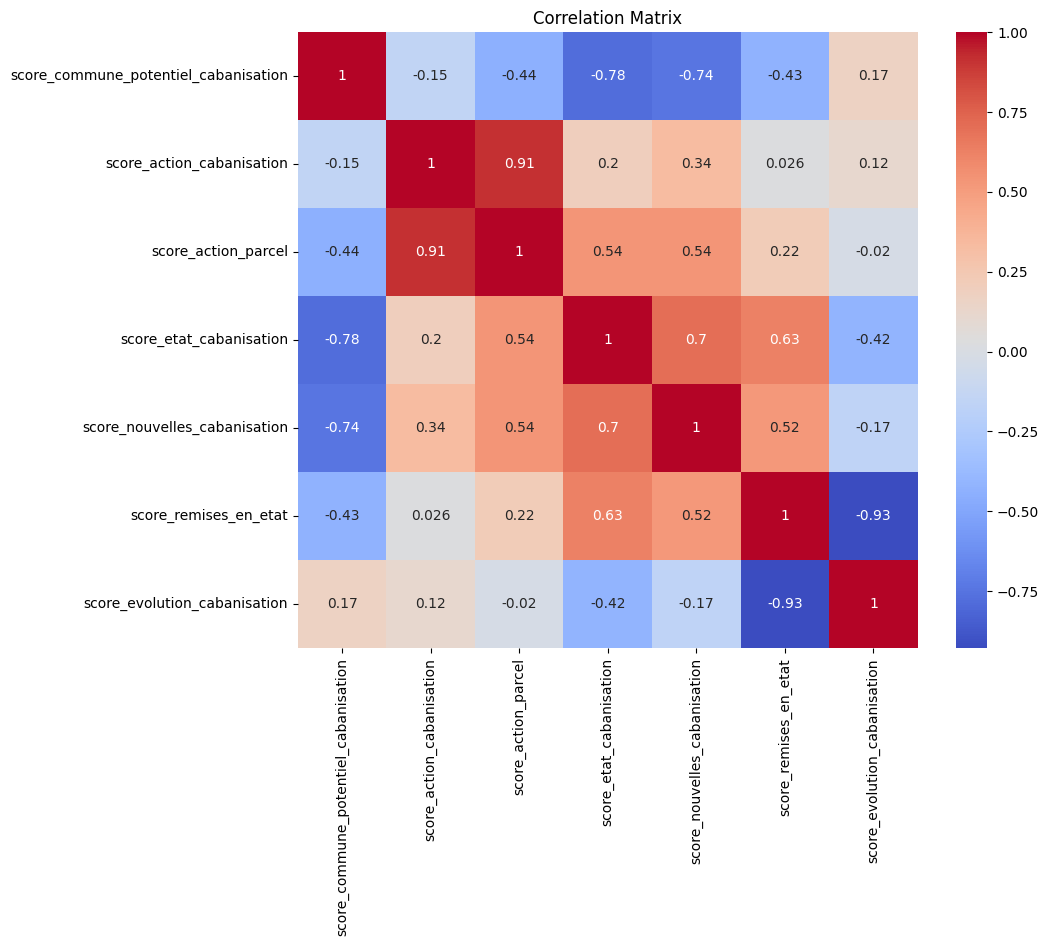

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()
